# CSE 6040 Project 
## Classifying Iron Meteorites by Logistic Regression

### Project Overview
This project utilizes the __NASA Meteorite Landings__ [1] dataset last updated in July 20, 2015, containing records of meteorite sightings in different geolocation. Meteorites are categorized based on their composition into stony (rocky), iron (metallic), or stony–iron (mixed) types. This analysis focuses on identifying iron meteorites using logistic regression model. Additionally, this project examines the relationship with other variables (year, location, degraded, etc.) with iron meteorites and determine their significance. 

In [1]:
## For Dataframe Computation
import pandas as pd
import numpy as np
## For Visualization & EDA
import matplotlib.pyplot as plt
import seaborn as sns
import geopandas as gpd
from scipy import stats
## For Logistic Regression
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import roc_curve, roc_auc_score, confusion_matrix, accuracy_score, precision_score, recall_score
from sklearn.metrics import log_loss

### Data Description
The dataset contains __45,717 meteorite__ information. Here are the variable information in order [2]:

1. __name__ : the name of the meteorite
2. __id__ : identifier for meteorite
3. __nametype__ : binary identifier of meteorite condition;
    1. valid : A meteorite with no degration by weather
    2. relict : A meteorite that has been highly degraded by weather on Earth
5. __recclass__ : classification of the meteorite. More info can be seen here : https://en.wikipedia.org/wiki/Meteorite_classification [3]
6. __mass__ : mass of the meteorite, in grams.
7. __fall__ : binary identifier whether the meteorite fell or was found.
8. __year__ : the year that the meteorite was found or fell.
9. __reclat__ : latitude of the meteorite's landing
10. __reclong__ : longitude of the meteorite's landing
11. __GeoLocation__ : tuple of the meteorite's landing location, (lat, long). 

Given the data, here are the following questions I would like to answer through the analysis :

1. Without knowing the composition of the meteorite, can a meteorite be identified based on its mass, location, and year of discovery?
2. What are the trends or patterns in the years when meteorites are discovered?
3. Is there a correlation between the discovery locations of meteorites?
4. Does the weathering process impact iron meteorites, considering their composition?

### Process Summary
1. __Data Cleaning__ : Impute missing values or remove. refine data ranges (year and location).
2. __EDA (Exploratory Data Analysis)__ : Investigate relationships between iron meteorites and other variables.
3. __Logistic Regression__ : Perform logistic regression to model and predict iron meteorites based on predictor variables.
4. __Model Assessment__ : Evaluate model accuracy using techniques such as confusion matrices and likelihood tests.

### Challenges 

1. The data is last updated until 2016 although it contains years that are greater than 2016.
2. The data contains missing values and values that are outside of conceptual range (e.g. longitude greater than 180 degrees).
3. The data does not contain information of meteorite composition, which may limit the prediction/accuracy of the logistic model. 

In [2]:
data = pd.read_csv('meteor.csv')

In [3]:
# Quick overview of data summary statistics.
data.describe()

,id,mass (g),year,reclat,reclong
count,45716.000000,4.558500e+04,45425.000000,38401.000000,38401.000000
mean,26889.735104,1.327808e+04,1991.828817,-39.122580,61.074319
std,16860.683030,5.749889e+05,25.052766,46.378511,80.647298
min,1.000000,0.000000e+00,860.000000,-87.366670,-165.433330
25%,12688.750000,7.200000e+00,1987.000000,-76.714240,0.000000
50%,24261.500000,3.260000e+01,1998.000000,-71.500000,35.666670
75%,40656.750000,2.026000e+02,2003.000000,0.000000,157.166670
max,57458.000000,6.000000e+07,2101.000000,81.166670,354.473330


### Data Cleaning
As shown from the short data description above, there are some datapoints that are not suitable for analysis. For example, the minimum year is 860 and maximum year is 2101, which seems unrealistic as the last data update was in 2015. Additionally, the longitude (reclong) has a maximum value of 354.5 degrees, exceeds the maximum of longitude, which is 180 degrees. I will begin by cleaning the dataset to remove these datapoints.

In [4]:
# Subset year to be within 860 and 2015.
data = data[(data['year'] >= 860) & (data['year'] <= 2015)]
# Subset longitude to be within -180 and 180 degrees.
data = data[(data['reclong'] <= 180) & (data['reclong'] >= -180)]

In [5]:
display(data.head())

,name,id,nametype,recclass,mass (g),fall,year,reclat,reclong,GeoLocation
0,Aachen,1,Valid,L5,21.0,Fell,1880.0,50.77500,6.08333,"(50.775, 6.08333)"
1,Aarhus,2,Valid,H6,720.0,Fell,1951.0,56.18333,10.23333,"(56.18333, 10.23333)"
2,Abee,6,Valid,EH4,107000.0,Fell,1952.0,54.21667,-113.00000,"(54.21667, -113.0)"
3,Acapulco,10,Valid,Acapulcoite,1914.0,Fell,1976.0,16.88333,-99.90000,"(16.88333, -99.9)"
4,Achiras,370,Valid,L6,780.0,Fell,1902.0,-33.16667,-64.95000,"(-33.16667, -64.95)"


In [6]:
# Check for missing values in each row. Missing values are shown as NaN.
missing_rows = data[data.isna().any(axis=1)]
display(missing_rows.head())

,name,id,nametype,recclass,mass (g),fall,year,reclat,reclong,GeoLocation
12,Aire-sur-la-Lys,425,Valid,Unknown,NaN,Fell,1769.0,50.66667,2.33333,"(50.66667, 2.33333)"
38,Angers,2301,Valid,L6,NaN,Fell,1822.0,47.46667,-0.55000,"(47.46667, -0.55)"
76,Barcelona (stone),4944,Valid,OC,NaN,Fell,1704.0,41.36667,2.16667,"(41.36667, 2.16667)"
93,Belville,5009,Valid,OC,NaN,Fell,1937.0,-32.33333,-64.86667,"(-32.33333, -64.86667)"
172,Castel Berardenga,5292,Valid,Stone-uncl,NaN,Fell,1791.0,43.35000,11.50000,"(43.35, 11.5)"


As we can see, there are several missing values within the field of mass, year, and location. Before moving on the analysis, it would be important to assess the missing values through imputation or removal. Due to Earth's orbit, there is a pattern in meteor showers. Therefore, in order to impute for the missing year values, I will find the nearest location and impute the year. If there is no location information of the meteorite, it will be removed. 

In [7]:
# Impute missing years by using the geographical information. 
# Using the missing year data latitude and longitude, 
# we can estimate the year it was missing as meteor citings are predictable with patterns.

# Extract missing year rows.
missing_years = data[data['year'].isnull()]

# Impute year based on latitude and longitude.
for index, row in missing_years.iterrows():
    lat = row['reclat']
    long = row['reclong']
    
    # Find nearest meteor landing with known year within a threshold distance.
    nearest_meteor = data[(data['reclat'] == lat) \
                          & (data['reclong'] == long) \
                          & (~data['year'].isnull())].sort_values(by='year')

    # If there is nearest meteor, replace the missing value with estimated year.
    if not nearest_meteor.empty:
        estimated_year = nearest_meteor.iloc[0]['year']
        data.at[index, 'year'] = estimated_year
    else:
        # If there is no geographical information, remove it.
        data.at[index, 'year'] = np.nan
        
# Removing rows with nan years.
data.dropna(subset=['year'], inplace=True)

In [8]:
imputed_year = data[data.isna().any(axis=1)] # just to check if missing year values are imputed. 

Next, in order to impute for location, I will use the similar method as previously by using the year of the meteorite discovery to estimate the location of the meteorite. The imputed value will be the average latitude and longitude of the year of discovery. 

In [9]:
# Identify rows with missing location values.
missing_geo = data[data['reclat'].isnull() | data['reclong'].isnull()]
# Group data by year and calculate average latitude and longitude.
yearly_coords = data.groupby('year')[['reclat', 'reclong']].mean().reset_index()

In [10]:
# Impute missing latitude and longitude based on nearest known year.
for index, row in missing_geo.iterrows():
    if pd.isnull(row['reclat']) or pd.isnull(row['reclong']):
        # Find nearest year with known location.
        nearest_year = yearly_coords.iloc[(yearly_coords['year'] - row['year']).abs().argsort()[:1]]['year'].values[0]
        
        # Use the average latitude and longitude of the known year.
        avg_lat = yearly_coords.loc[yearly_coords['year'] == nearest_year, 'reclat'].values[0]
        avg_long = yearly_coords.loc[yearly_coords['year'] == nearest_year, 'reclong'].values[0]
        
        # Impute missing latitude and longitude with average values of the nearest year.
        data.at[index, 'reclat'] = avg_lat
        data.at[index, 'reclong'] = avg_long
        data.at[index, 'GeoLocation'] = (avg_lat, avg_long)

In [11]:
imputed_loc = data[data.isna().any(axis=1)] # just to check if missing location values are imputed. 
print(len(imputed_loc))

107


The final process of imputation requires both year and location to estimate meteorite mass. The imputed value is the median value of the nearest location in the nearest year. 

In [12]:
# Group data to calculate median mass.
grouped_mass = data.groupby(['reclat', 'reclong', 'year'])['mass (g)'].median().reset_index()

In [13]:
# Identify rows with missing mass.
missing_mass = data[data['mass (g)'].isnull()]

# Impute missing mass based on nearest geolocation and year.
for index, row in missing_mass.iterrows():
    if pd.isnull(row['mass (g)']):
        # Find nearest group with known mass.
        nearest_group = grouped_mass.iloc[(((grouped_mass['reclat'] - row['reclat'])**2 + 
                                            (grouped_mass['reclong'] - row['reclong'])**2 +
                                            (grouped_mass['year'] - row['year'])**2)
                                           .argsort()[:1])]
        
        if not nearest_group['mass (g)'].isnull().all():
            # Use the median mass of the nearest known group.
            median_mass = nearest_group['mass (g)'].values[0]
        else:
            # If there is no location info, use the median mass across the entire dataset.
            median_mass = data['mass (g)'].median()
        
        # Impute missing mass with the selected median mass value.
        data.at[index, 'mass (g)'] = median_mass


In [14]:
imputed_mass = data[data.isna().any(axis=1)] # just to check if missing mass values are imputed. 
print(len(imputed_mass))

0


Now that we have finished imputation and resulted with no missing values, I will store the imputed data separately as __meteor__ and add in additional binary variables for modeling. The __Iron__ variable contains a binary information of whether the meteorite is classified to be iron or not. Those that have iron substance will contain 'Iron' inside the recclass variable. Additionally, I will create another binary variable, __Valid__, that gives the information if the meteorite was degraded by weather or not by setting 1 if valid, 0 if not. 

In [15]:
# Store the cleaned data as meteor.
meteor = data.copy()
# Create binary variables based on criteria.
meteor['Iron'] = meteor['recclass'].apply(lambda x: 1 if 'Iron' in x else 0) # 1 : Iron, 0 : Non-Iron
meteor['Valid'] = meteor['nametype'].apply(lambda x: 1 if 'Valid' in x else 0) # 1 : Valid, 0 : Degraded by Weather
display(meteor.head())

,name,id,nametype,recclass,mass (g),fall,year,reclat,reclong,GeoLocation,Iron,Valid
0,Aachen,1,Valid,L5,21.0,Fell,1880.0,50.77500,6.08333,"(50.775, 6.08333)",0,1
1,Aarhus,2,Valid,H6,720.0,Fell,1951.0,56.18333,10.23333,"(56.18333, 10.23333)",0,1
2,Abee,6,Valid,EH4,107000.0,Fell,1952.0,54.21667,-113.00000,"(54.21667, -113.0)",0,1
3,Acapulco,10,Valid,Acapulcoite,1914.0,Fell,1976.0,16.88333,-99.90000,"(16.88333, -99.9)",0,1
4,Achiras,370,Valid,L6,780.0,Fell,1902.0,-33.16667,-64.95000,"(-33.16667, -64.95)",0,1


### EDA (Exploratory Data Analysis)
The EDA will serve a primary purpose of investigating the relationship between iron meteorites and other variables. 

#### EDA - 1 : Iron VS Non-Iron meteorite summary statistics and t-test

In [16]:
iron_data = meteor[meteor['Iron'] == 1]
non_iron_data = meteor[meteor['Iron'] == 0]
print("Iron Meteorites Summary Statistics:")
print(iron_data['mass (g)'].describe())
print("\nNon-Iron Meteorites Summary Statistics:")
print(non_iron_data['mass (g)'].describe())

Iron Meteorites Summary Statistics:
count    9.890000e+02
mean     5.182488e+05
std      3.860153e+06
min      6.000000e-01
25%      1.240000e+03
50%      1.020000e+04
75%      4.400000e+04
max      6.000000e+07
Name: mass (g), dtype: float64

Non-Iron Meteorites Summary Statistics:
count    3.723200e+04
mean     2.204724e+03
std      4.797881e+04
min      0.000000e+00
25%      6.430000e+00
50%      2.740000e+01
75%      1.610000e+02
max      4.300000e+06
Name: mass (g), dtype: float64


Given the summary statistics, we can notice that despite the number of iron meteorites (989) is significantly smaller than the non-iron meteorites (37232), the mean mass of iron meteorites is 197.95% greater than the non-iron meteorites. There seems to be a possible correlation between mass and meteorite content. In order to test the theory, a t-test was performed. 

In [17]:

iron_mass = iron_data['mass (g)'].dropna()
non_iron_mass = non_iron_data['mass (g)'].dropna()

t_stat, p_value = stats.ttest_ind(iron_mass, non_iron_mass, equal_var=False)
print("t-statistic : ")
print(t_stat)
print("p-value : ")
print(p_value)

t-statistic : 
4.2041633833117995
p-value : 
2.8581530910135515e-05


Given the test result, the t-statistic value is 4.204 and given p-value is 2.858e-05. Since the p-value is significantly less than 0.05, we can reject the null hypothesis (there is no difference in mean mass between iron and non-iron meteorites). Therefore, there is statistically significant difference in mean masses between iron meteorites and non-iron meteorites, with iron meteorites having a higher mean mass compared to non-iron meteorites.

#### EDA - 2 : GeoLocation distribution of Iron and Non-Iron Meteorites

C:\Users\yeban\AppData\Local\Temp\ipykernel_12396\1648461017.py:9: FutureWarning: The geopandas.dataset module is deprecated and will be removed in GeoPandas 1.0. You can get the original 'naturalearth_lowres' data from https://www.naturalearthdata.com/downloads/110m-cultural-vectors/.
  world = gpd.read_file(gpd.datasets.get_path('naturalearth_lowres'))


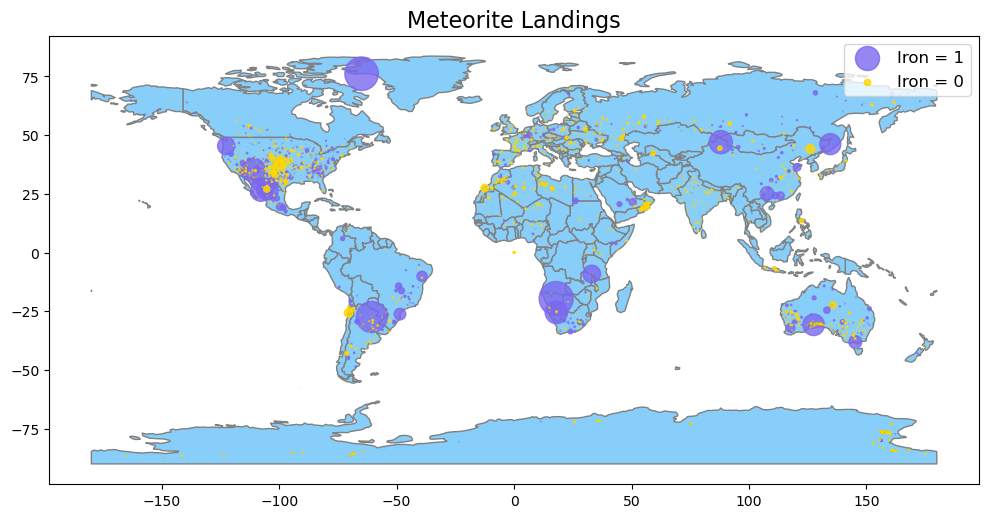

In [18]:

# Create separate GeoDataFrames for iron and noniron.
iron = gpd.GeoDataFrame(meteor[meteor['Iron'] == 1], geometry=gpd.points_from_xy(meteor[meteor['Iron'] == 1]['reclong'],\
                                                        meteor[meteor['Iron'] == 1]['reclat']))

non_iron = gpd.GeoDataFrame(meteor[meteor['Iron'] == 0], geometry=gpd.points_from_xy(meteor[meteor['Iron'] == 0]['reclong'],\
                                                               meteor[meteor['Iron'] == 0]['reclat']))
# Geopandas was used [4].
# Set up the plot by loading world map.
world = gpd.read_file(gpd.datasets.get_path('naturalearth_lowres')) 
ax = world.plot(figsize=(12, 8), color='lightskyblue', edgecolor='gray')  # Plot world map as base layer.

# Plot iron (purple) in the map.
iron.plot(ax=ax, marker='o', color='mediumslateblue', markersize=iron['mass (g)'] / 100000, alpha=0.8, label='Iron = 1')

# Plot non-iron (yellow) in the map.
non_iron.plot(ax=ax, marker='o', color='gold', markersize=non_iron['mass (g)'] / 100000, alpha=0.8, label='Iron = 0')

ax.legend(loc='upper right', fontsize=12)
plt.title('Meteorite Landings', fontsize=16)
plt.show()

Given the locational distribution of meteorites, we can see that there is not much of a significant difference between iron and non-iron distribution in terms of location. It is however, noticable that the iron meteorites are found within continents whereas the non-iron meteorites are not contained within continents. Of course, this might be due to the fact that there are significantly more meteorites that does not contain iron than those that does. However, we can investigate this further using a boxplot in the next EDA.

#### EDA - 3 : Iron VS. Non-Iron Boxplots

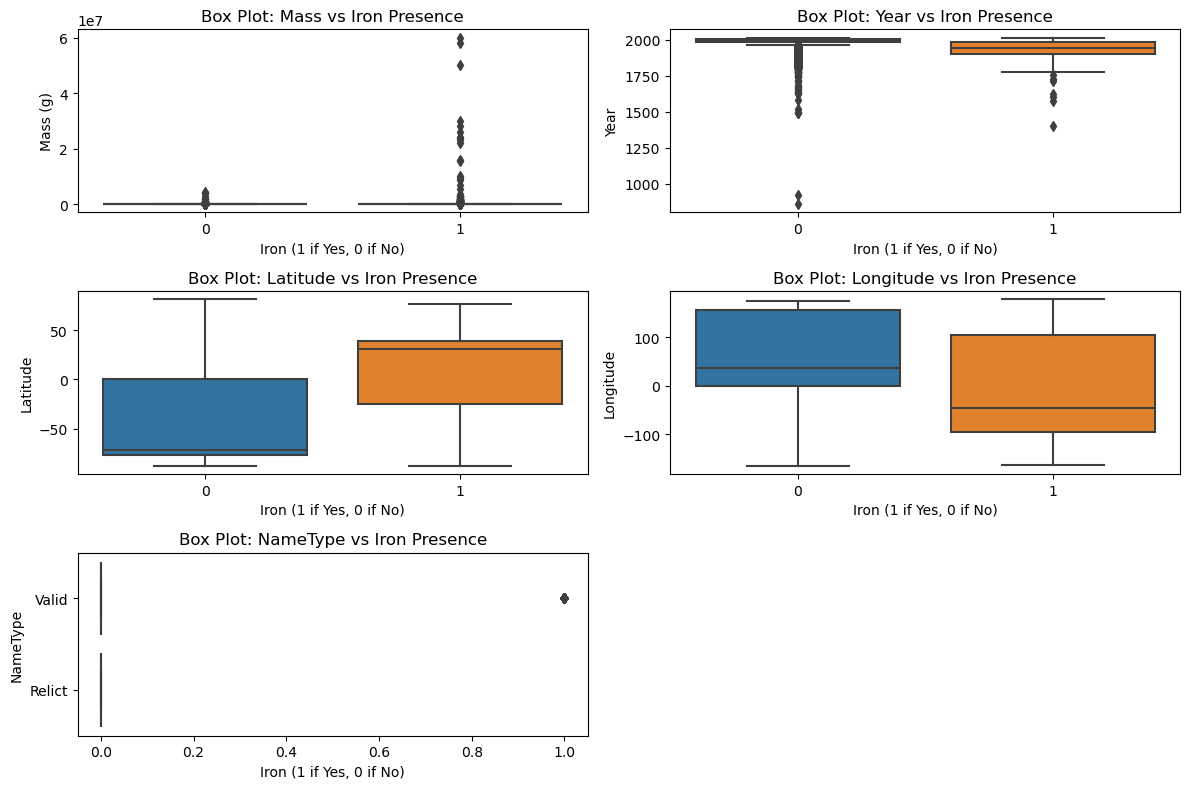

In [19]:
# Create a box plot for each variable vs iron presence.
plt.figure(figsize=(12, 8))

# Mass vs Iron
plt.subplot(3, 2, 1)
sns.boxplot(x='Iron', y='mass (g)', data=meteor)
plt.xlabel('Iron (1 if Yes, 0 if No)')
plt.ylabel('Mass (g)')
plt.title('Box Plot: Mass vs Iron Presence')

# Year vs Iron
plt.subplot(3, 2, 2)
sns.boxplot(x='Iron', y='year', data=meteor)
plt.xlabel('Iron (1 if Yes, 0 if No)')
plt.ylabel('Year')
plt.title('Box Plot: Year vs Iron Presence')

# Latitude vs Iron
plt.subplot(3, 2, 3)
sns.boxplot(x='Iron', y='reclat', data=meteor)
plt.xlabel('Iron (1 if Yes, 0 if No)')
plt.ylabel('Latitude')
plt.title('Box Plot: Latitude vs Iron Presence')

# Longitude vs Iron
plt.subplot(3, 2, 4)
sns.boxplot(x='Iron', y='reclong', data=meteor)
plt.xlabel('Iron (1 if Yes, 0 if No)')
plt.ylabel('Longitude')
plt.title('Box Plot: Longitude vs Iron Presence')

# Nametype vs Iron
plt.subplot(3, 2, 5)
sns.boxplot(x='Iron', y='nametype', data=meteor)
plt.xlabel('Iron (1 if Yes, 0 if No)')
plt.ylabel('NameType')
plt.title('Box Plot: NameType vs Iron Presence')

plt.tight_layout()
plt.show()

From these boxplots, I observed the following relationships :

1. Iron meteorites may be found more in northern hemisphere (higher latitude) and non-iron meteorites may be found more in the southern hemisphere.
2. Iron meteorites may be found more in the western hemisphere (lower longitude) and non-iron meteories may be found more in the eastern hemisphere.
3. There are no iron meteorites that are degraded by Earth's weather. 

#### EDA - 4 : Time Analysis of Iron VS. Non-Iron Meteorites

<Figure size 1200x400 with 0 Axes>

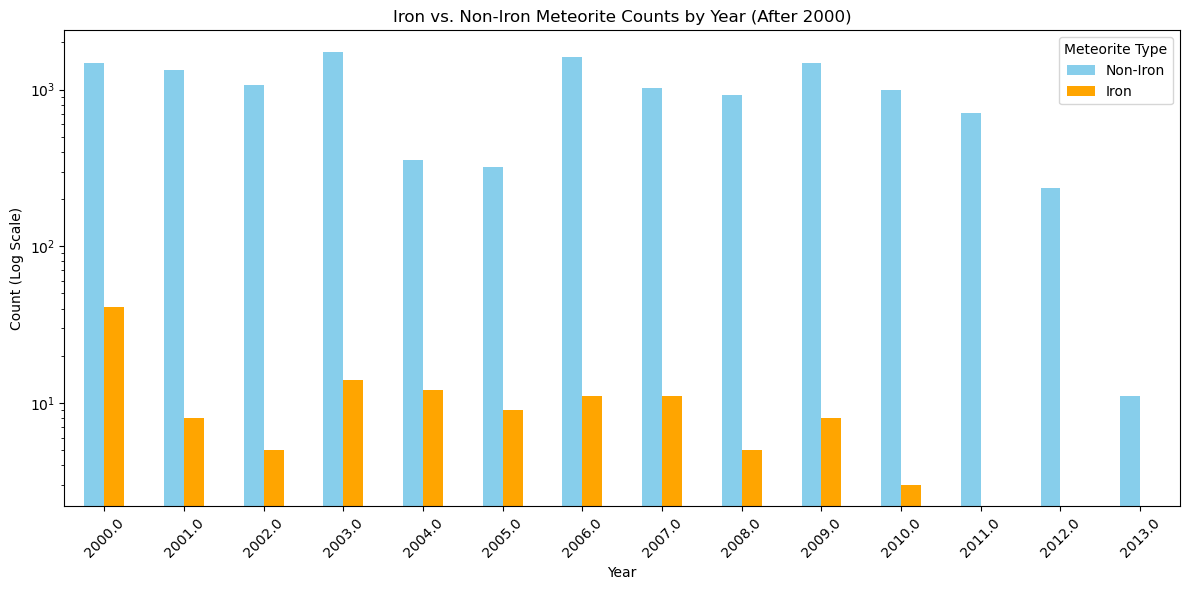

In [21]:

plt.figure(figsize=(12, 4))

# Filter data for years greater than 2000.
meteor_subset = meteor[meteor['year'] >= 2000]

# Group by year and iron and count. 
meteor_counts = meteor_subset.groupby(['year', 'Iron']).size().unstack(fill_value=0)

# Rename the columns.
meteor_counts.columns = ['Non-Iron', 'Iron']

# Plotting the count by year plot.
# Will use log scale to make it more readable (non-iron has significantly more datapoints than iron).
ax = meteor_counts.plot(kind='bar', stacked=False, color=['skyblue', 'orange'], figsize=(12, 6))
ax.set_yscale('log')  # Set scale to logarithmic.

plt.title('Iron vs. Non-Iron Meteorite Counts by Year (After 2000)')
plt.xlabel('Year')
plt.ylabel('Count (Log Scale)')
plt.legend(title='Meteorite Type', labels=['Non-Iron', 'Iron'])
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()


Since the number of non-iron meteorites is significantly greater than iron meteorites, the plot was added a logarithmic scale to adjust the height. Given the logarithmic scale of the number of meteorites, it seems that there may be a time series pattern, which may require a further investigation using time series models such as ARIMA or Holt Winters. 

#### Summary from EDA 
1. There is statistical significance that iron meteorites has higher mass than non-iron meteorites.
2. There may be locational pattern with the meteorites classes.
3. There may be a time series seasonal pattern of meteorite sitings. 

### Perform Logistic Regression
Now that we have examined the relationship of variables with regard to meteorite classification, I will now fit a logistic regression model to determine whether we can predict a meteorite class using the given predictors. In order to do so, the first step of modeling would be splitting the data for validation.

##### Splitting Data - Training/Validation/Testing

In [22]:
# Define variables and response.
var = ['mass (g)', 'year', 'reclat', 'reclong', 'Valid']
X = meteor[var]
y = meteor['Iron']  

# Split the data into training (80%) and testing (20%).
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=1389)

# Split again the training data into training (75%) and validation (25%).
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.25, random_state=1389)

# Let's check each dataset counts.
print("Training set:", X_train.shape, y_train.shape)
print("Validation set:", X_val.shape, y_val.shape)
print("Testing set:", X_test.shape, y_test.shape)

Training set: (22932, 5) (22932,)
Validation set: (7644, 5) (7644,)
Testing set: (7645, 5) (7645,)


##### Fit Logistic Model

In [23]:
# Initialize and train the logistic regression model [5].
# setting to balanced as non-iron has significantly more datapoints than iron.
logreg = LogisticRegression(random_state=1389, class_weight='balanced')
logreg.fit(X_train, y_train)

LogisticRegression(class_weight='balanced', random_state=1389)

##### Assess Model Accuracy - 1 : ROC Curve

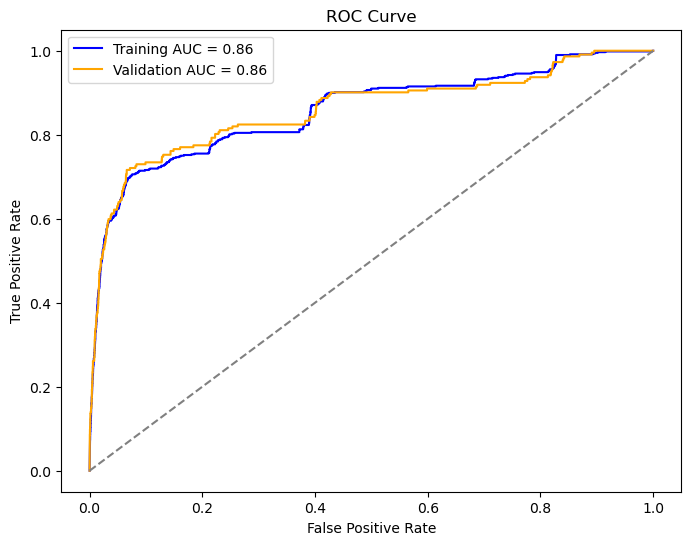

In [24]:
# Predict and calculate ROC curve [6].
y_train_prob = logreg.predict_proba(X_train)[:, 1]
y_val_prob = logreg.predict_proba(X_val)[:, 1]

fpr_train, tpr_train, _ = roc_curve(y_train, y_train_prob)
fpr_val, tpr_val, _ = roc_curve(y_val, y_val_prob)

# Calculate AUC scores.
# One on training and one on validation. 
auc_train = roc_auc_score(y_train, y_train_prob)
auc_val = roc_auc_score(y_val, y_val_prob)

# Now let's plot the ROC curve.
plt.figure(figsize=(8, 6))
plt.plot(fpr_train, tpr_train, label=f'Training AUC = {auc_train:.2f}', color='blue')
plt.plot(fpr_val, tpr_val, label=f'Validation AUC = {auc_val:.2f}', color='orange')
plt.plot([0, 1], [0, 1], linestyle='--', color='gray')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve')
plt.legend()
plt.show()


An AUC closer to 1 suggests a good model. From this logistic model, the AUC of the training data was 0.86 and the AUC on the validation data was 0.86. Since this value is somewhat close to 1 and greater than 0.5, it would suggest that the model is good at predicting iron meteorites from the variables. Additionally, the AUC of the training and AUC of the validation has a close value to each other. This suggests that the model generalizes reasonably well on randomness. 

##### Assess Model Accuracy - 2 : Confusion Matrix & Accuracy

In [25]:
# Predict on the test set.
y_pred = logreg.predict(X_test)

# Compute confusion matrix.
cm = confusion_matrix(y_test, y_pred)
print("Confusion Matrix:")
print(cm)

# Compute accuracy and precision. 
accuracy = accuracy_score(y_test, y_pred)
precision = precision_score(y_test, y_pred)

# Calculate Log Likelihood [7].
y_true = np.array(y_train)
y_pred = np.array(y_train_prob)
log_likelihood = log_loss(y_true, y_pred)


print(f"Accuracy: {accuracy:.2f}")
print(f"Precision: {precision:.2f}")
print(f"Log Likelihood: {log_likelihood:.2f}")


Confusion Matrix:
[[6094 1372]
 [  43  136]]
Accuracy: 0.81
Precision: 0.09
Log Likelihood: 0.47


Here is the interpretation of the confusion matrix :
1. The model accurately predicted 136 iron meteorites (True Positive)
2. The model accurately predicted 6094 non-iron meteorites (True Negative)
3. The model inaccurately predicted 1372 as iron-meteorites (False Positive)
4. The model inaccurately predicted 43 as non-iron meteorites (False Negative)

Given the accuracy of 0.81 and the precision of 0.09, it seems that the model is identifying very few true iron meteorites. Additionally, the calculated log likelihood is 0.47, which is not high. It would be important to assess this by trimming the model.

In [26]:
# Let's take a look at the model coefficients and intercept.
coef = logreg.coef_
intercept = logreg.intercept_

print("Intercept:")
print(intercept)
print("Coefficients:")
print(coef)

Intercept:
[1.61306647e-05]
Coefficients:
[[ 4.85068169e-05 -7.74571913e-05  1.41610779e-02 -2.44221929e-03
   1.84551097e-05]]


In [28]:
# Change coef array to list and remove nested list.
c = []
for l in coef.tolist():
    for i in l:
        c.append(i)
# Create dataframe of coefficients.
coef_df = pd.DataFrame({'Feature': var, 'Coefficient': c})
# Add abs magnitude of coeff and sort by greatest to smallest. 
# Larger magnitude has more impact on response.
coef_df['Magnitude'] = coef_df['Coefficient'].abs() 
coef_df = coef_df.sort_values(by='Magnitude', ascending=False).reset_index(drop=True)
print(coef_df)

    Feature  Coefficient  Magnitude
0    reclat     0.014161   0.014161
1   reclong    -0.002442   0.002442
2      year    -0.000077   0.000077
3  mass (g)     0.000049   0.000049
4     Valid     0.000018   0.000018


Given the coefficients and their absolute magnitude, it was surprising to see that the location of the meteorite had higher influence on the response than the mass. Now that we can see the effect of the variables, I will prepare another logistic model with only the location variables and see its effect on the model. 

### Perform Logistic Regression V2

##### Splitting Data - Training/Validation/Testing

In [29]:
# Define variables and response.
# Keep only location data.
var = ['reclat', 'reclong']
X = meteor[var]
y = meteor['Iron']  

# Split the data into training (80%) and testing (20%).
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=1389)

# Split again the training data into training (75%) and validation (25%).
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.25, random_state=1389)


##### Fit Logistic Model

In [30]:
# Initialize and train the logistic regression model [5].
# setting to balanced as non-iron has significantly more datapoints than iron.
logreg = LogisticRegression(random_state=1389, class_weight='balanced')
logreg.fit(X_train, y_train)

LogisticRegression(class_weight='balanced', random_state=1389)

##### Assess Model Accuracy - 1 : ROC Curve

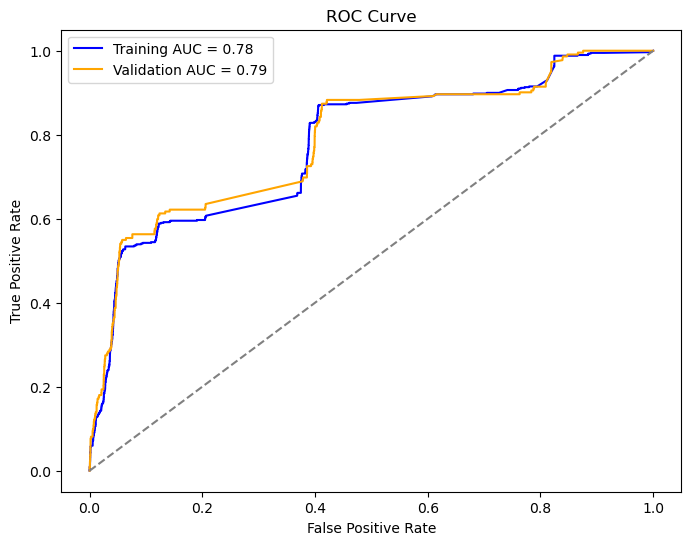

In [31]:
# Predict and calculate ROC curve [6].
y_train_prob = logreg.predict_proba(X_train)[:, 1]
y_val_prob = logreg.predict_proba(X_val)[:, 1]

fpr_train, tpr_train, _ = roc_curve(y_train, y_train_prob)
fpr_val, tpr_val, _ = roc_curve(y_val, y_val_prob)

# Calculate AUC scores.
# One on training and one on validation. 
auc_train = roc_auc_score(y_train, y_train_prob)
auc_val = roc_auc_score(y_val, y_val_prob)

# Now let's plot the ROC curve.
plt.figure(figsize=(8, 6))
plt.plot(fpr_train, tpr_train, label=f'Training AUC = {auc_train:.2f}', color='blue')
plt.plot(fpr_val, tpr_val, label=f'Validation AUC = {auc_val:.2f}', color='orange')
plt.plot([0, 1], [0, 1], linestyle='--', color='gray')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve')
plt.legend()
plt.show()

##### Assess Model Accuracy - 2 : Confusion Matrix & Accuracy

In [32]:
# Predict on the test set.
y_pred = logreg.predict(X_test)

# Compute confusion matrix.
cm = confusion_matrix(y_test, y_pred)
print("Confusion Matrix:")
print(cm)

# Compute accuracy and precision. 
accuracy = accuracy_score(y_test, y_pred)
precision = precision_score(y_test, y_pred)

# Calculate Log Likelihood [7].
y_true = np.array(y_train)
y_pred = np.array(y_train_prob)
log_likelihood = log_loss(y_true, y_pred)


print(f"Accuracy: {accuracy:.2f}")
print(f"Precision: {precision:.2f}")
print(f"Log Likelihood: {log_likelihood:.2f}")

Confusion Matrix:
[[4448 3018]
 [  46  133]]
Accuracy: 0.60
Precision: 0.04
Log Likelihood: 0.56


Keeping only the location variables, the model has become lass accurate. Its AUC values, accuracy, and precision values is lower than the previous model. However, the log likelihood is greater, which indicates that the model is inefficient of predicting the response (low accuracy) but has higher probabilities to predict. Comparing the two models, given the higher accuracy, AUC, and precision, as well as the EDA and t-test of mass VS Iron, I would still choose model 1 as a better candidate to explaining and predicting the response. 

## Conclusion
Based on the model evaluations and the coefficients observed in the initial analysis, predicting iron meteorites solely based on mass and location data appears challenging without additional composition details. Incorporating composition data is essential for enhancing prediction accuracy and model efficiency. However, despite not having the composition of the meteorites, the models still hold significance. With more data points on iron meteorites or additional composition details, the model could be further refined and optimized for more precise predictions. Additionally, it would be important to explore other models such as random forest or decision trees to classify or predict the iron meteorites. To examine the relationship between iron meteorites and year and forecast meteorites, it would be helpful to use time series models such as Holt Winter Exponential Smoothing model or ARIMA.s.

### Works Cited
1. https://data.nasa.gov/Space-Science/Meteorite-Landings/gh4g-9sfh/about_data 
2. https://www.kaggle.com/datasets/nasa/meteorite-landings 
3. https://en.wikipedia.org/wiki/Meteorite_classification
4. https://levelup.gitconnected.com/beginners-tutorial-on-how-to-use-python-s-geopandas-map-library-e6fb0db8132
5. https://www.datacamp.com/tutorial/understanding-logistic-regression-python
6. https://scikit-learn.org/stable/modules/generated/sklearn.metrics.roc_curve.html
7. https://stackoverflow.com/questions/48185090/how-to-get-the-log-likelihood-for-a-logistic-regression-model-in-sklearn